# Baseline Model

In [1]:
%load_ext autoreload
%autoreload 2
#%reload_ext autoreload
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import geopandas
import geopy
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, make_scorer
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium.plugins as plugins
import math
from math import sin, cos, sqrt, atan2, radians
from haversine import haversine
from itertools import combinations
import json
%matplotlib inline
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)
import sys
import os

In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier

## Import Clean Dataset

In [23]:
df = pd.read_csv('../data/df_clean.csv')
df.head()

,id,date_recorded,funder,gps_height,installer,longitude,latitude,basin,subvillage,region,district_code,lga,ward,public_meeting,permit,construction_year,extraction_type,management,payment,water_quality,quantity,source,waterpoint_type,status_group,pop_log,year_recorded,age
0,69572,2011-03-14,roman,1390.0,roman,34.94,-9.86,Lake Nyasa,mnyusi b,Iringa,5,Ludewa,Mundindi,True,False,1999,gravity,vwc,pay annually,soft,enough,spring,communal standpipe,functional,4.691348,2011,12
1,8776,2013-03-06,grumeti,1399.0,grumeti,34.70,-2.15,Lake Victoria,nyamara,Mara,2,Serengeti,Natta,True,True,2010,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional,5.634790,2013,3
2,34310,2013-02-25,lottery club,686.0,world vision,37.46,-3.82,Pangani,majengo,Manyara,4,Simanjiro,Ngorika,True,True,2009,gravity,vwc,pay per bucket,soft,enough,dam,communal standpipe multiple,functional,5.521461,2013,4
3,67743,2013-01-28,unicef,263.0,unicef,38.49,-11.16,Ruvuma / Southern Coast,mahakamani,Mtwara,63,Nanyumbu,Nanyumbu,True,True,1986,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional,4.060443,2013,27
4,19728,2011-07-13,action in a,1300.0,artisan,31.13,-1.83,Lake Victoria,kyanyamisa,Kagera,1,Karagwe,Nyakasimbi,True,True,1997,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional,5.991465,2011,14


In [24]:
# convert numerical category to object
df.district_code = df.district_code.astype(object)

reminder of features have high cardinality and will therefore cause issues if one hot encoded

In [25]:
for col in df.columns:
    print(col)
    print(len(df[col].value_counts()))
    print('\n')

id
59400


date_recorded
356


funder
1884


gps_height
3435


installer
1919


longitude
1274


latitude
1249


basin
9


subvillage
19268


region
21


district_code
20


lga
125


ward
2092


public_meeting
2


permit
2


construction_year
54


extraction_type
18


management
12


payment
7


water_quality
8


quantity
5


source
10


waterpoint_type
7


status_group
3


pop_log
1050


year_recorded
5


age
61




In [26]:
# remove any category with a high cardinality from analysis
col_to_drop = ['lga', 'ward', 'subvillage', 'installer', 'funder']


Now I have an age feature I can drop year_recorded, date_recorded and construction_year

In [27]:
redundant_cols = ['year_recorded', 'date_recorded', 'construction_year', 'id']

In [28]:
# drop the columns from the dataframe
drops = col_to_drop + redundant_cols
df.drop(drops, axis=1, inplace=True)

## Split into Train / Test

In [29]:
X = df.drop('status_group', axis=1)
y = df['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [30]:
# print info as a reminder as to which categories are continuous and therefore need scaled
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gps_height       59400 non-null  float64
 1   longitude        59400 non-null  float64
 2   latitude         59400 non-null  float64
 3   basin            59400 non-null  object 
 4   region           59400 non-null  object 
 5   district_code    59400 non-null  object 
 6   public_meeting   59400 non-null  bool   
 7   permit           59400 non-null  bool   
 8   extraction_type  59400 non-null  object 
 9   management       59400 non-null  object 
 10  payment          59400 non-null  object 
 11  water_quality    59400 non-null  object 
 12  quantity         59400 non-null  object 
 13  source           59400 non-null  object 
 14  waterpoint_type  59400 non-null  object 
 15  pop_log          59400 non-null  float64
 16  age              59400 non-null  int64  
dtypes: bool(2), 

## Scaling

I will now scale the continuous features, and onehotencode the categorical features in both the train and the test split separately.

In [34]:
# Instantiate StandardScaler
scaler = StandardScaler()
ohe = OneHotEncoder()
continuous = ['gps_height', 'longitude', 'latitude', 'pop_log', 'age']

#continuous dataframes
X_train_cont = X_train[continuous]
X_test_cont = X_test[continuous]

# categorical dataframes
X_train_cat = X_train.drop(continuous, axis=1)
X_test_cat = X_test.drop(continuous, axis=1)

# Transform the training and test sets
scaled_X_train_cont = scaler.fit_transform(X_train_cont)
scaled_X_test_cont = scaler.transform(X_test_cont)

# Convert into a DataFrame
scaled_df_train_cont = pd.DataFrame(scaled_X_train_cont, columns=X_train_cont.columns)
scaled_df_test_cont = pd.DataFrame(scaled_X_test_cont, columns=X_test_cont.columns)


In [35]:
# apply one hot encoder
ohe_train = ohe.fit_transform(X_train_cat).toarray()
ohe_test = ohe.transform(X_test_cat).toarray()

In [36]:
# create one hot encoded dataframes
ohe_train_df = pd.DataFrame(ohe_train, columns=ohe.get_feature_names(X_train_cat.columns))
ohe_test_df = pd.DataFrame(ohe_test, columns=ohe.get_feature_names(X_test_cat.columns))

In [37]:
# merge continuous and categorical dataframes
final_train = pd.concat([ohe_train_df, scaled_df_train_cont],axis=1)
final_test = pd.concat([ohe_test_df, scaled_df_test_cont],axis=1)

#check equal number of columns
print(final_train.shape)
print(final_test.shape)

(44550, 126)
(14850, 126)


## Baseline Model 

In [39]:
# instantiate logisitic regression
logreg = LogisticRegression(solver='saga', 
                            random_state=42, 
                            multi_class='ovr',
                            max_iter=10000,
                           n_jobs=-1)

In [40]:
# fit the model
model_log = logreg.fit(final_train, y_train)

In [41]:
# get prediction for train and test
y_hat_train = model_log.predict(final_train)
y_hat_test = model_log.predict(final_test)

### Classification Reports

In [43]:
print(classification_report(y_train, y_hat_train))

                         precision    recall  f1-score   support

             functional       0.72      0.90      0.80     24161
functional needs repair       0.55      0.06      0.10      3243
         non functional       0.79      0.65      0.72     17146

               accuracy                           0.74     44550
              macro avg       0.69      0.54      0.54     44550
           weighted avg       0.74      0.74      0.72     44550



In [44]:
print(classification_report(y_test, y_hat_test))

                         precision    recall  f1-score   support

             functional       0.72      0.90      0.80      8098
functional needs repair       0.52      0.06      0.10      1074
         non functional       0.79      0.65      0.71      5678

               accuracy                           0.74     14850
              macro avg       0.68      0.53      0.54     14850
           weighted avg       0.73      0.74      0.72     14850



In [68]:
from  sklearn.metrics import precision_recall_fscore_support, precision_recall_curve


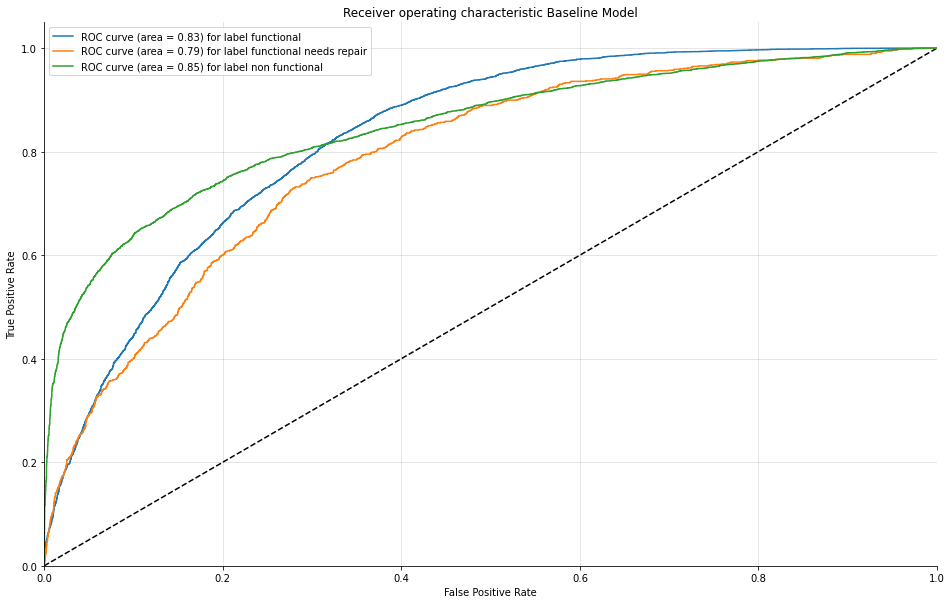

In [130]:
# https://stackoverflow.com/questions/45332410/roc-for-multiclass-classification
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6), title='Example'):
    y_score = clf.decision_function(X_test)
    
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    y_test_names = list(pd.get_dummies(y_test, drop_first=False).columns)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic {}'.format(title))
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = {}) for label {}'.format(round(roc_auc[i],2),\
                                                                                 y_test_names[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(model_log, final_test, y_test, n_classes=3, title= 'Baseline Model', figsize=(16, 10))

In [131]:
def plot_multi_pr(y_test, n_classes, y_score, figsize=(17, 6), title='Example'):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([1, 0], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.01])
    ax.set_ylim([0.0, 1])
    precision = dict()
    recall = dict()
    pr_auc = dict()
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    y_test_names = list(pd.get_dummies(y_test, drop_first=False).columns)
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_dummies[:, i], y_score[:, i])
        pr_auc[i] = auc(recall[i],precision[i])
        plt.plot(recall[i], precision[i], lw=2, label='{} (Area={})'.format(y_test_names[i], round(pr_auc[i],3)))
    
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve {}".format(title))
    plt.show()
    #print(pr_auc)

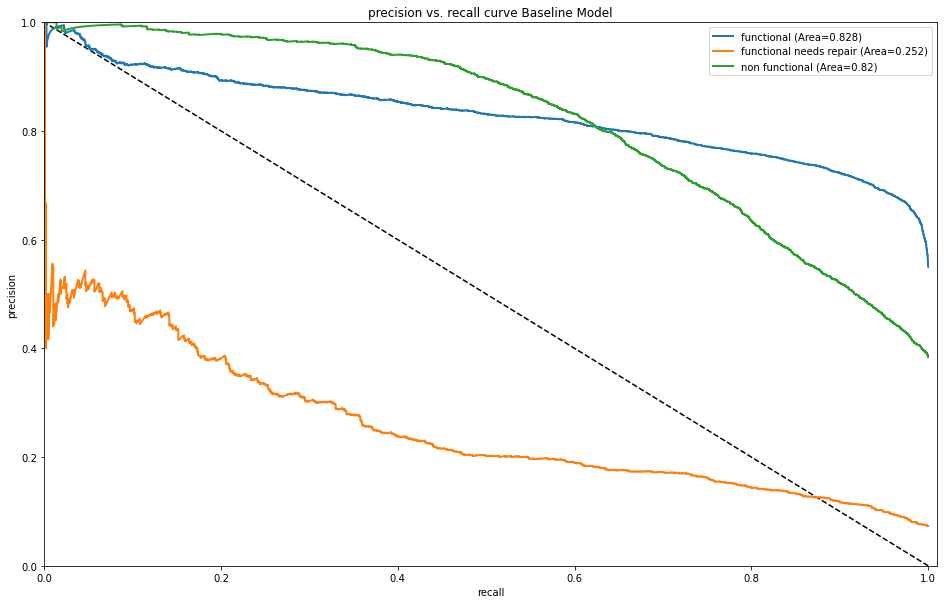

In [132]:
plot_multi_pr(y_test, 3, y_score, figsize=(16,10), title='Baseline Model')

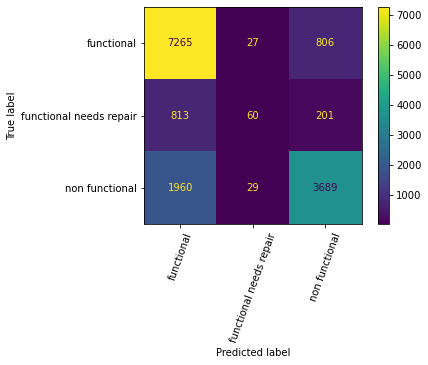

In [125]:
plot_confusion_matrix(model_log, final_test, y_test, xticks_rotation=70)  
plt.show() 

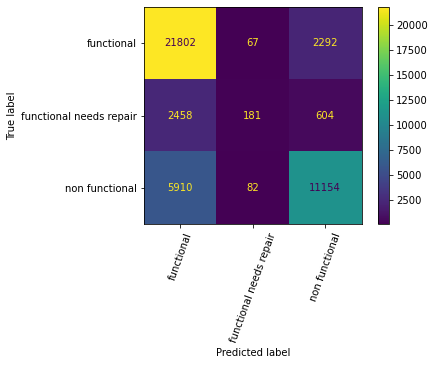

In [129]:
plot_confusion_matrix(model_log, final_train, y_train, xticks_rotation=70)  
plt.show() 

# Summary


The model accuracy is good (0.74 for both the train and test set) but this can be a deceptive metric, the precision and recall for 'functional needs repair' is poor, this is a class that we want to reduce the number of false negatives, if this is improved that means the pumps in need of repair can be fixed before they breakdown altogether. The poor score in the functional needs repair class could be due to the imbalance in the dataset - there are relatively few instances of this class compared to the other two.

In [135]:
df2 = df.copy()
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
number_selector = make_column_selector(dtype_include='number', dtype_exclude=['object', 'bool'])
string_selector = make_column_selector(dtype_include=['object', 'bool'])

preprocessing = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), string_selector),
                                        (StandardScaler(), number_selector),
                                       remainder='passthrough')


In [146]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gps_height       59400 non-null  float64
 1   longitude        59400 non-null  float64
 2   latitude         59400 non-null  float64
 3   basin            59400 non-null  object 
 4   region           59400 non-null  object 
 5   district_code    59400 non-null  object 
 6   public_meeting   59400 non-null  bool   
 7   permit           59400 non-null  bool   
 8   extraction_type  59400 non-null  object 
 9   management       59400 non-null  object 
 10  payment          59400 non-null  object 
 11  water_quality    59400 non-null  object 
 12  quantity         59400 non-null  object 
 13  source           59400 non-null  object 
 14  waterpoint_type  59400 non-null  object 
 15  status_group     59400 non-null  object 
 16  pop_log          59400 non-null  float64
 17  age         

In [136]:
preprocessing.fit_transform(df2.drop(columns='status_group'))

<59400x126 sparse matrix of type '<class 'numpy.float64'>'
	with 1009800 stored elements in Compressed Sparse Row format>

In [137]:
preprocessing.transformers_[0][1].get_feature_names()

array(['x0_Internal', 'x0_Lake Nyasa', 'x0_Lake Rukwa',
       'x0_Lake Tanganyika', 'x0_Lake Victoria', 'x0_Pangani',
       'x0_Rufiji', 'x0_Ruvuma / Southern Coast', 'x0_Wami / Ruvu',
       'x1_Arusha', 'x1_Dar es Salaam', 'x1_Dodoma', 'x1_Iringa',
       'x1_Kagera', 'x1_Kigoma', 'x1_Kilimanjaro', 'x1_Lindi',
       'x1_Manyara', 'x1_Mara', 'x1_Mbeya', 'x1_Morogoro', 'x1_Mtwara',
       'x1_Mwanza', 'x1_Pwani', 'x1_Rukwa', 'x1_Ruvuma', 'x1_Shinyanga',
       'x1_Singida', 'x1_Tabora', 'x1_Tanga', 'x2_0', 'x2_1', 'x2_2',
       'x2_3', 'x2_4', 'x2_5', 'x2_6', 'x2_7', 'x2_8', 'x2_13', 'x2_23',
       'x2_30', 'x2_33', 'x2_43', 'x2_53', 'x2_60', 'x2_62', 'x2_63',
       'x2_67', 'x2_80', 'x3_False', 'x3_True', 'x4_False', 'x4_True',
       'x5_afridev', 'x5_cemo', 'x5_climax', 'x5_gravity',
       'x5_india mark ii', 'x5_india mark iii', 'x5_ksb', 'x5_mono',
       'x5_nira/tanira', 'x5_other', 'x5_other - mkulima/shinyanga',
       'x5_other - play pump', 'x5_other - rope pump',
   

In [140]:
from sklearn.pipeline import make_pipeline
full_pipeline = make_pipeline(preprocessing, LogisticRegression(solver='saga', 
                            random_state=42, 
                            multi_class='ovr',
                            max_iter=10000,
                           n_jobs=-1))

In [141]:
cross_val_score(full_pipeline, df2.drop(columns='status_group'), df2.status_group)

array([0.74537, 0.74108, 0.7404 , 0.73687, 0.74689])

In [142]:
full_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002040974C3A0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002040974C100>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=10000, multi_class='ovr',
                                    n_jobs=-1, random_state=42,
                                    solver='saga'))])

In [143]:
full_pipeline[0]

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002040974C3A0>),
                                ('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002040974C100>)])

In [144]:
full_pipeline[1]

LogisticRegression(max_iter=10000, multi_class='ovr', n_jobs=-1,
                   random_state=42, solver='saga')

In [147]:
#save model df to file:
df.to_csv('..\data\df_model.csv', index=False)